# Mocap Data Pre-processing

In [ ]:
using LinearAlgebra, Statistics, Random
using Distributions, MultivariateStats   # Categorical, PCA
using Quaternions    # For manipulating 3D Geometry
using MeshCat        # For web visualisation / animation
using PyPlot         # Plotting
using AxUtil, Flux   # Optimisation

# small utils libraries
using ProgressMeter, Formatting, ArgCheck
using DelimitedFiles, NPZ, BSON

In [2]:
DIR_MOCAP_MTDS = "../../../mocap-mtds/";   # different cos I'm in dev folder

# Data loading and transformation utils
include(joinpath(DIR_MOCAP_MTDS, "io.jl"))

# MeshCat skeleton visualisation tools
include(joinpath(DIR_MOCAP_MTDS, "mocap_viz.jl"))

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-4380146875587178885\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-14412905055608324179\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/5794a0bf2e6325e42dc09c7369026176a04edd3e-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-4380146875587178885\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

Main.mocapviz

In [ ]:
cmu_loco = readdlm("../cmu/cmu_locomotion_lkp.txt", '\t')[:,1];
database = "cmu"
files_cmu = [joinpath(database, f * ".bvh") for f in cmu_loco]
files_cmu = collect(filter(x-> isfile(x) && x !== "rest.bvh", files_cmu));

database = "../edin-style-transfer/"
files_edin = [joinpath(database, f) for f in readdir(database)];

### Read in example data

In [9]:
# Extract exemplars for each Edinburgh style
style_name_edin = [x[1] for x in match.(r"\.\./[a-z\-]+/([a-z]+)_.*", files_edin)];
styles = unique(style_name_edin)

Random.seed!(12929)
_is = [x[rand(Categorical(x/sum(x)))] for x in [findall(style_name_edin .== k) for k in styles]]
styles_edin = Dict(style_name_edin[i] => 
    mocapio.reconstruct_raw(mocapio.process_file(files_edin[i])) for i in _is);
display([k=>size(x,1) for (k,x) in styles_edin])

8-element Array{Pair{SubString{String},Int64},1}:
     "angry" => 2223
 "childlike" => 4143
 "depressed" => 3820
      "sexy" => 5713
       "old" => 3949
     "proud" => 4436
   "neutral" => 3377
 "strutting" => 4669

In [ ]:
proc = process_file(files[40]);   # 54 = PACING/STOP, 40 = BACKWARD, 115=TRIUMPHANT, 190=TWISTY, not 198 (JUMP)!

## Look at principal components

In [12]:
?mocapio.construct_outputs

```
construct_outputs(raw [; include_ftcontact])
```

Construct the output matrix for the mocap models. The input `raw` is the raw output from the `process_file` function. The function outputs the following matrix, which contains only the range of frames: [start+69, end-60](i.e.) excluding approx. the first and last second. This is in order to match with the input matrix which needs these boundaries in order to construct trajectories consistently. This function outputs a matrix with the following columns:

  * (3): rotational velocity, x-velocity, z-velocity
  * (61): (Lagrangian) joint positions (excl. root x/z ∵ always zero)
  * (4): [optional] feet contacts

These are the minimal requirements to reconstruct an animation of human motion on the target skeleton. The feet contacts are in {0,1} and may be challenging for some linear models, therefore they are optional (see named argument     `include_ftcontact` (Bool)).


In [11]:
allE = reduce(vcat, Ys);
allE = convert(Matrix{Float32}, allE);

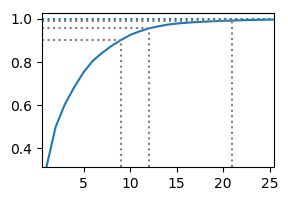

In [20]:
zsc(x, dims) = (x .- mean(x, dims=dims)) ./ std(x, dims=dims)

pc_all = fit(PCA, zsc(allE[:,4:63]', 1), pratio=0.999)

varexpl = cumsum(principalvars(pc_all))/tvar(pc_all)
bd=findfirst.([varexpl .> x for x in [0.9,0.95,0.99]])
plot(1:length(varexpl), varexpl)
gca().axhline(1, linestyle=":")
for b in bd
    plot([b,b], [varexpl[1], varexpl[b]], color=ColorMap("tab10")(7), linestyle=":")
    plot([.5, b], [varexpl[b], varexpl[b]], color=ColorMap("tab10")(7), linestyle=":")
end
gca().set_xlim(0.5,25.5); gca().set_ylim(varexpl[1],1.025);
gcf().set_size_inches(3,2)

#### Note
This is different (worse, i.e. need more PCs) than the graph I showed to Chris. This is because I was in the Eulerian frame, where direction(s) of movement probably captured most of PCs. Removing these high variance directions, common to all joints makes it much harder.

## Getting ready for training

In [ ]:
# Load data from raw BVH files (1-2 mins), or load a saved version
DATA_FROM_SAVED = true

if DATA_FROM_SAVED
    Xs = BSON.load("edin_Xs.bson")[:Xs];
    Ys = BSON.load("edin_Ys.bson")[:Ys];
else
    Xs = map(files_edin) do f
        proc = mocapio.process_file(f);
        convert(Matrix{Float32}, mocapio.construct_inputs(proc))
    end;
    println("Xs finished processing...")
    Ys = map(files_edin) do f
        proc = mocapio.process_file(f);
        convert(Matrix{Float32}, 
            mocapio.construct_outputs(proc; include_ftcontact=false))
    end;
    println("Ys finished processing...")
    
    println("Do you want to save? (y/n)")
    
    for i = 1:10
        userinput = uppercase(chomp(readline()))[1]
        if userinput == 'Y'
            println("SAVING...")
            BSON.bson("edin_Xs.bson", Xs=Xs)
            BSON.bson("edin_Ys.bson", Ys=Ys)
            break
        elseif userinput == 'N'
            break
        end
    end
end

### Need to standardize inputs and outputs